Q1. iris data를 불러와서 아래 사항을 수행하세요.

- 결정트리 모델을 시각화하고 주요한 인사이트를 기술하세요.(tree.plot_tree 이용)
- Feature importance를 추출하고 시각화하세요.

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

iris_data = load_iris()
X_train,X_test,y_train,y_test = train_test_split(iris_data.data, iris_data.target,
                                                test_size=0.2, random_state=11)
# dt_clf = DecisionTreeClassifier()
dt_clf = DecisionTreeClassifier(max_depth=3)
# dt_clf = DecisionTreeClassifier(min_samples_split=4)
# dt_clf = DecisionTreeClassifier(min_samples_leaf=4)
dt_clf.fit(X_train,y_train)
pred = dt_clf.predict(X_test)


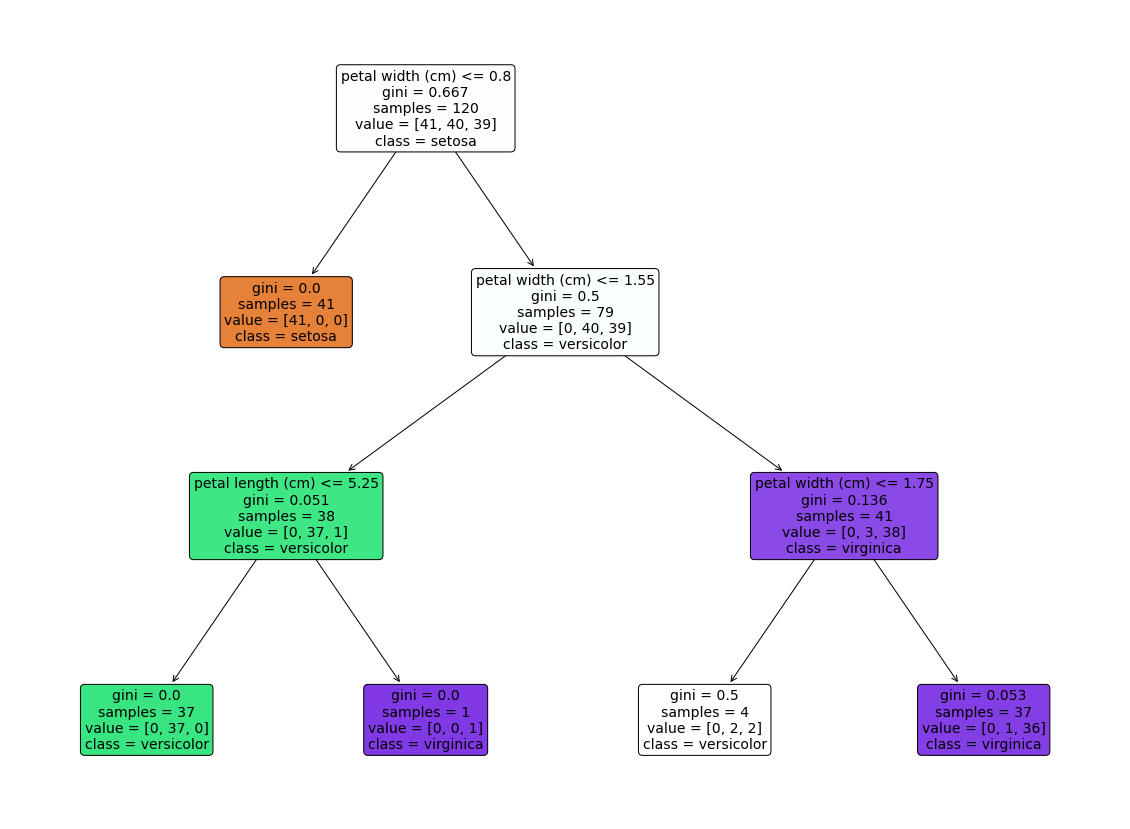

In [28]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
tree.plot_tree(dt_clf, filled=True,
              feature_names=iris_data.feature_names,
              class_names=iris_data.target_names,
              rounded=True, fontsize=14)
plt.show()
plt.close()

인사이트
- petal_width <= 0.8가 일차적인 분류 규칙

Feature importances:
[0.     0.     0.0256 0.9744]
sepal length (cm): 0.0000
sepal width (cm): 0.0000
petal length (cm): 0.0256
petal width (cm): 0.9744


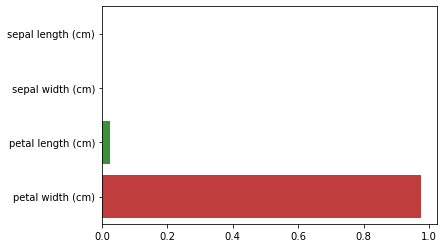

In [29]:
import seaborn as sns
import numpy as np

# feature importance 추출
print('Feature importances:\n{0}'.\
      format(np.round(dt_clf.feature_importances_,4)))
# feature별 importance 매핑
for name, value in zip(iris_data.feature_names,\
                       dt_clf.feature_importances_):
    print('{0}: {1:.4f}'.format(name,value))
# feature importance를 column별로 시각화
sns.barplot(x=dt_clf.feature_importances_, y=iris_data.feature_names)

Q2~Q3. 'dataset/creditcard.csv'를 불러와서 신용카드 사기 검출 분류문제를 아래와 같이 수행하세요
- 로지스틱 리그레션을 적용한 모델 학습 및 사용자 함수를 이용하여 평가
    - 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 df 반환하는 사용자 함수 생성
    - 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수(테스트 사이즈 0.3)
    - 오차행렬, 정확도, 정밀도, 재현율, f1, AUC 평가 함수
    
- 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서  학습/예측/평가 수행
    - 사용자 함수를 사용하여 LightGBM으로 모델을 학습한 뒤 별도의 테스트 데이터 세트에서 예측 평가를 수행. 단, n_estimators=1000, num_leaves=64 적용<br>  ※ 레이블 값이 극도로 불균형한 분포를 가지고 있는 경우 boost_from_average=False로 파라미터 설정(default=True). default 설정은 재현율, AUC 성능을 매우 크게 저하시킴
    - 넘파이의 np.log1p( )를 이용하여 Amount를 로그 변환하는 사용자 함수 생성
    - Amount를 로그 변환 후 로지스틱 회귀 및 LightGBM 수행.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

card_df = pd.read_csv('dataset/creditcard.csv')
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [31]:
# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 df 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time',axis=1,inplace=True)
    return df_copy

In [32]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수
from sklearn.model_selection import train_test_split
def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                       test_size=0.3, random_state=0,
                                                       stratify=y_target)
    return X_train,X_test,y_train,y_test
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [33]:
# 오차행렬, 정확도, 정밀도, 재현율, f1, AUC 평가 함수
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, \
f1_score, roc_auc_score

def get_clf_eval(y_test,pred,pred_proba):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    auc = roc_auc_score(y_test,pred_proba)
    print('오차 행렬\n',confusion)    
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, auc))

In [34]:
# 로지스틱 리그레션을 적용한 모델 학습 및 평가
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]
get_clf_eval(y_test,lr_pred, lr_pred_proba)

오차 행렬
 [[85282    13]
 [   57    91]]
정확도: 0.9992, 정밀도: 0.8750, 재현율: 0.6149,    F1: 0.7222, AUC:0.9616


In [35]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서 
# 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, 
                         tgt_train=None, tgt_test=None):
    model.fit(ftr_train,tgt_train)
    pred=model.predict(ftr_test)
    pred_proba=model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test,pred,pred_proba)

In [36]:
# 레이블 값이 극도로 불균형한 분포를 가지고 있는 경우 boost_from_average=False로
# 파라미터 설정(default=True). default 설정은 재현율, AUC 성능을 매우 크게 저하시킴
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, 
                         boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, 
                     tgt_train=y_train, tgt_test=y_test)

오차 행렬
 [[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


In [37]:
# 넘파이의 np.log1p( )를 이용하여 Amount를 로그 변환
def get_preprocessed_df(df=None):
    df_copy = df.copy()    
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [38]:
# Amount를 로그 변환 후 로지스틱 회귀 및 LightGBM 수행. 
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, 
                     tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, 
                     tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
 [[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
 [[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796


Q4. Q2 신용카드 사기 검출 분류문제에서 아래를 참고하여 이상치 데이터를 제거하고 모델 학습/예측/평가를 수행하세요
- 히트맵을 이용해 레이블과의 상관성을 시각화 
- 레이블과 상관성이 높은 피처를 위주로 이상치 검출하는 사용자 함수 생성
- 사용자 함수를 이용하여 이상치 검출
- 이상치 제거 사용자 함수를 이용하여 이상치 제거 후 로지스틱 회귀 및 LightGBM 수행 및 평가

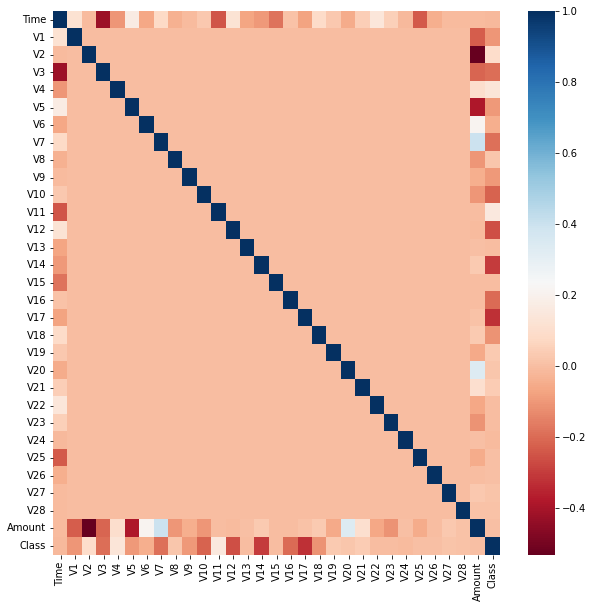

In [39]:
import seaborn as sns

plt.figure(figsize=(10,10))
corr = card_df.corr()
# print(corr)
sns.heatmap(corr, cmap='RdBu')

In [40]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 
    # np.percentile로 구함.
    fraud = df[df.Class==1][column]
    qt_25 = np.percentile(fraud.values,25)
    qt_75 = np.percentile(fraud.values,75)

    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = qt_75 - qt_25
    iqr_weight = iqr*weight
    lowest_val = qt_25 - iqr_weight
    highest_val = qt_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 
    # DataFrame index 반환.
    outlier_index = fraud[(fraud<lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [41]:
# 이상치 데이터 인덱스 출력
outlier_index = get_outlier(df=card_df, column='V14',weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [42]:
outlier_index = get_outlier(df=card_df, column='V17',weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([], dtype='int64')


In [43]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경.
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, 
                     tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, 
                     tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
 [[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
 [[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9780


Q5. SMOTE 오버 샘플링 적용 후 LightGBM 모델을 이용하여 학습, 예측, 평가를 수행하세요.(10점)

In [44]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train,y_train)
print('SMOTE 적용전:', X_train.shape, y_train.shape)
print('SMOTE 적용후:', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용후 레이블 값 분포:\n', pd.Series(y_train_over).value_counts())

SMOTE 적용전: (199362, 29) (199362,)
SMOTE 적용후: (398040, 29) (398040,)
SMOTE 적용후 레이블 값 분포:
 1    199020
0    199020
Name: Class, dtype: int64


In [45]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1,
                         boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                    tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
 [[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493,    F1: 0.8794, AUC:0.9814


Q6. 사이킷런에서 제공해주는 load_boston 데이터셋을 가져와서 아래 사항을 수행하세요.(10점)
- 데이터셋의 타겟 이름을 'PRICE'로 지정한 후 데이터프레임을 생성 pickle 파일로 저장 후 다시 불어오세요.
- 히트맵을 이용하여 타겟과 상관관계가 높은 독립 변수를 선택하세요.
- 종속변수를 로그 변환하세요
- 위의 사항을 반영하여 선회회귀 모델을 생성 후 평가하고 회귀계수를 출력하세요.

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston

house = load_boston()
house.keys()

house_df = pd.DataFrame(house.data, columns = house.feature_names)
house_df['PRICE'] = house.target
house_df.to_pickle('./dataset/house_df.pkl')
house_df = pd.read_pickle('./dataset/house_df.pkl')
house_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


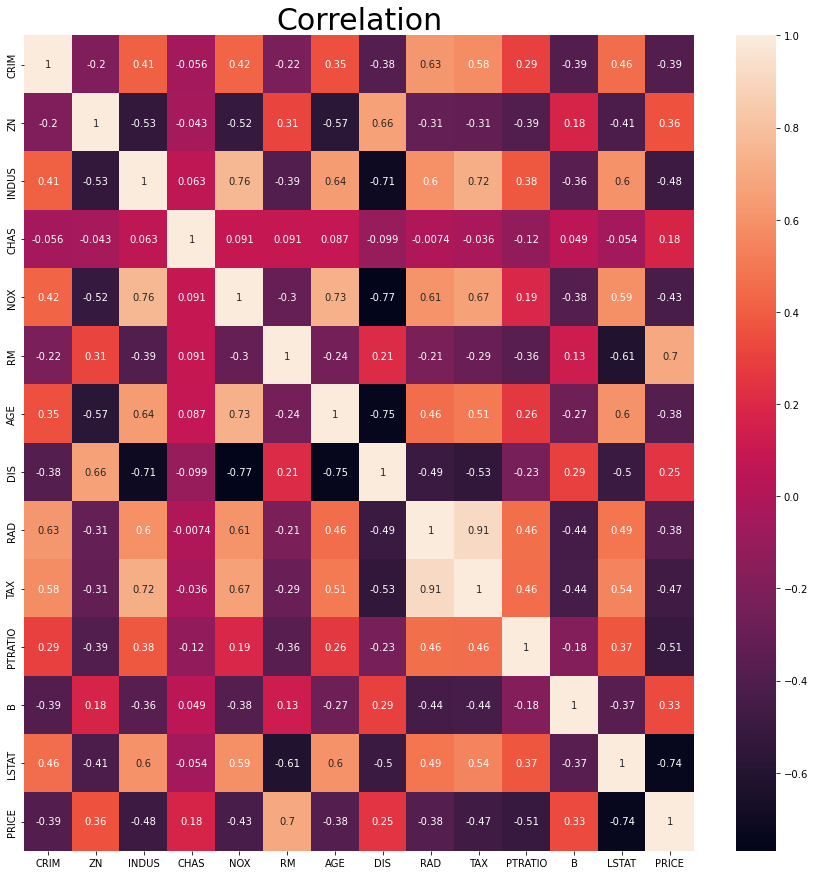

In [47]:
plt.figure(figsize=(15,15))
plt.title('Correlation', fontsize=30)
sns.heatmap(house_df.corr(),annot=True)

In [48]:
# 종속변수 로그 변환 및 독립변수 선택
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# sns.distplot(house_df.PRICE)
X=house_df[['RM', 'ZN', 'INDUS', 'NOX', 'AGE', 'PTRATIO', 'LSTAT','RAD']]
y=house_df['PRICE']
y_log = np.log1p(house_df['PRICE'])

X_train, X_test, y_train, y_test = \
train_test_split(X,y_log,test_size=0.3,random_state=1)

lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)

mse = mean_squared_error(y_test_exp, y_pred_exp)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_exp,y_pred_exp)
print('MSE : {:.3f}, RMSE : {:.3f}, R2 score : {:.3f}'.format(mse,rmse,r2))
print('절편 값 : ', lr.intercept_)
print('회귀 계수값 : ',np.round(lr.coef_, 1))

MSE : 24.572, RMSE : 4.957, R2 score : 0.732
절편 값 :  4.161068564990513
회귀 계수값 :  [ 0.1 -0.   0.  -0.7  0.  -0.  -0.   0. ]


Q7. house_df.pkl 데이터셋을 불러와서 아래사항을 수행하세요.(15점)
- alphas = [0, 0.1, 1, 10, 100] 를 적용하여 Ridge 회귀 모델링 및 교차 검증 수행 후 5 폴드 평균 RMSE 출력 
- lasso_alphas = [0.07,0.1,0.5,1,3] 를 적용, Lasso 회귀 모델링 및 교차 검증 수행 후 5 폴드 평균 RMSE 출력(def get_linear_reg_eval(model_name,params=None,X_data_n=None, y_target_n=None, verbose=True 사용자 함수 이용) 
- elastic_alphas = [0.07,0.1,0.5,1,3] 를 적용, ElasticNet 회귀 모델링 및 교차검증 후 5 폴드 평균 RMSE를 출력(사용자 함수 이용)

In [49]:
import pandas as pd
# from sklearn.datasets import load_boston

# house = load_boston()
house_df = pd.read_pickle('./dataset/house_df.pkl')
y_target = house_df['PRICE']
X_data = house_df.drop(['PRICE'], axis=1, inplace=False)

In [3]:
house_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [50]:
# 릿지 회귀
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

alphas = [0, 0.1, 1, 10, 100]
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    
    neg_mse_scores = cross_val_score(ridge, X_data, y_target,\
                                    scoring="neg_mean_squared_error"\
                                    ,cv=5)
    avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
    print('alpha {}일 때 5 folds의 평균 RMSE : {:.3f}'.format(alpha,\
                                                         avg_rmse))

alpha 0일 때 5 folds의 평균 RMSE : 5.829
alpha 0.1일 때 5 folds의 평균 RMSE : 5.788
alpha 1일 때 5 folds의 평균 RMSE : 5.653
alpha 10일 때 5 folds의 평균 RMSE : 5.518
alpha 100일 때 5 folds의 평균 RMSE : 5.330


In [51]:
# 라쏘 회귀
from sklearn.linear_model import Lasso, ElasticNet
def get_linear_reg_eval(model_name,params=None,X_data_n=None, 
                        y_target_n=None, verbose=True):
    coeff_df = pd.DataFrame()
    if verbose : print('####### ', model_name , '#######')
    for param in params:
        if model_name == 'Ridge':model = Ridge(alpha=param)
        elif model_name == 'Lasso':model = Lasso(alpha=param)
        elif model_name == 'ElasticNet':model = ElasticNet(alpha=param, \
                                                          l1_ratio=0.7)
        neg_mse_scores = \
        cross_val_score(model,X_data_n,y_target_n, \
                        scoring="neg_mean_squared_error", cv=5)
        avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
        print('alpha {}일 때 5 폴드 세트의 평균 RMSE: {:3f}'\
              .format(param, avg_rmse))
        model.fit(X_data,y_target)
        coeff = pd.Series(data=model.coef_, index=X_data.columns)
        colname = 'alpha:'+str(param)
        coeff_df[colname] = coeff
    return coeff_df    

In [52]:
lasso_alphas = [0.07,0.1,0.5,1,3]
coeff_lasso_df = get_linear_reg_eval('Lasso',params=lasso_alphas,\
                                    X_data_n=X_data,y_target_n=y_target)

#######  Lasso #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612284
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615116
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669123
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776021
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.188763


In [53]:
# 엘라스틱넷 회귀
elastic_alphas = [0.07,0.1,0.5,1,3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet',\
                                       params = elastic_alphas,
                                      X_data_n=X_data,\
                                       y_target_n=y_target)

#######  ElasticNet #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.541654
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.525928
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.466749
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.596874
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068122


Q8. load_boston 데이터셋을 불러와서 다음사항을 수행하세요.
- SVM 알고리즘을 활용한 주택가격 예측모델 생성 및 평가(MSE, RMSE, R2)
- 개발된 예측모델을 활용하여 아래 test_data가 주어졌은때의 주택가격 예측<br>
test_data = [3.7, 0, 18.4, 1, 0.87, 5.95, 91, 2.5052, 26, 666, 20.2, 351.34, 15.27]

In [54]:
import numpy as np
from sklearn import datasets
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle

data = datasets.load_boston()

X, y = shuffle(data.data, data.target, random_state = 7)

num_training = int(0.8 * len(X))
X_train, y_train = X[:num_training], y[:num_training]
X_test, y_test = X[num_training:], y[num_training:]

# Create Support Vector Regression model
# kernel : 선형 커널
# C : 학습 오류에 대한 패널티, C 값이 클 수록 모델이 학습 데이터에 좀 더 최적화 됨, 너무 크면 오버피팅 발생
# Epsilon : 임계값, 예측한 값이 GT 범위 안에 있으면 패널티 부여 X
sv_regressor = SVR(kernel='linear', C=1.0, epsilon=0.1)

sv_regressor.fit(X_train, y_train)

y_pred = sv_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,y_pred)
print(f'mse:{mse:.3f}','\n')
print(f'rmse:{rmse:.3f}','\n')
print(f'r2:{r2:.3f}','\n')
test_data = [3.7, 0, 18.4, 1, 0.87, 5.95, 91, 2.5052, 26, 666, 20.2, 351.34, 15.27]
print('예측값:', np.round(sv_regressor.predict([test_data])[0],3))

mse:15.377 

rmse:3.921 

r2:0.813 

예측값: 18.522


Q9. mtcars 데이터셋(mtcars.csv)의 qsec 컬럼을 최소최대 척도(Min-Max Scale)로 변환한 후 0.5보다 
큰 값을 가지는 레코드 수를 구하시오

In [55]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

df = pd.read_csv('dataset/mtcars.csv',index_col=0)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(data=scaled, columns=df.columns)
print(len(scaled_df[scaled_df.qsec > 0.5]))

9


Q10. purdata.csv는 백화점 고객의 1년 간 구매 데이터이다. 아래사항을 수행하세요.
 
- 남성고객을 분류하는 모델을 생성(분류알고리즘 : dt,rf,lr)
- 모델 성능을 roc_auc로 평가 

In [56]:
# df.to_csv('./dataset/purdata.csv',index=False)
df = pd.read_csv('./dataset/purdata.csv')
df.head()

,cust_id,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기,gender
0,0,68282840,11264000,6860000.0,기타,강남점,19,3.894737,0.527027,17,0
1,1,*,2136000,300000.0,스포츠,잠실점,2,1.500000,0.000000,1,0
2,2,3197000,1639000,NaN,남성 캐주얼,관악점,2,2.000000,0.000000,1,1
3,3,*,4935000,NaN,기타,광주점,18,2.444444,0.318182,16,1
4,4,29050000,24000000,NaN,보석,본 점,2,1.500000,0.000000,85,0


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cust_id  3500 non-null   int64  
 1   총구매액     3500 non-null   object 
 2   최대구매액    3500 non-null   int64  
 3   환불금액     1205 non-null   float64
 4   주구매상품    3500 non-null   object 
 5   주구매지점    3500 non-null   object 
 6   내점일수     3500 non-null   int64  
 7   내점당구매건수  3500 non-null   float64
 8   주말방문비율   3500 non-null   float64
 9   구매주기     3500 non-null   int64  
 10  gender   3500 non-null   int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 300.9+ KB


In [58]:
df.총구매액.unique()

array(['68282840', '*', '3197000', ..., '75000', '1875000', '263101550'],
      dtype=object)

In [59]:
# index 활용한 삭제
idx = df[df.총구매액 == '*'].index
df = df.drop(idx)

In [60]:
df['총구매액'] = df.총구매액.astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3498 entries, 0 to 3499
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cust_id  3498 non-null   int64  
 1   총구매액     3498 non-null   float64
 2   최대구매액    3498 non-null   int64  
 3   환불금액     1204 non-null   float64
 4   주구매상품    3498 non-null   object 
 5   주구매지점    3498 non-null   object 
 6   내점일수     3498 non-null   int64  
 7   내점당구매건수  3498 non-null   float64
 8   주말방문비율   3498 non-null   float64
 9   구매주기     3498 non-null   int64  
 10  gender   3498 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 327.9+ KB


In [61]:
df.head()

,cust_id,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기,gender
0,0,68282840.0,11264000,6860000.0,기타,강남점,19,3.894737,0.527027,17,0
2,2,3197000.0,1639000,NaN,남성 캐주얼,관악점,2,2.000000,0.000000,1,1
4,4,29050000.0,24000000,NaN,보석,본 점,2,1.500000,0.000000,85,0
5,5,11379000.0,9552000,462000.0,디자이너,일산점,3,1.666667,0.200000,42,0
6,6,10056000.0,7612000,4582000.0,시티웨어,강남점,5,2.400000,0.333333,42,0


In [62]:
df.reset_index(inplace=True)
df.head()

,index,cust_id,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기,gender
0,0,0,68282840.0,11264000,6860000.0,기타,강남점,19,3.894737,0.527027,17,0
1,2,2,3197000.0,1639000,NaN,남성 캐주얼,관악점,2,2.000000,0.000000,1,1
2,4,4,29050000.0,24000000,NaN,보석,본 점,2,1.500000,0.000000,85,0
3,5,5,11379000.0,9552000,462000.0,디자이너,일산점,3,1.666667,0.200000,42,0
4,6,6,10056000.0,7612000,4582000.0,시티웨어,강남점,5,2.400000,0.333333,42,0


In [63]:
X_data = df.drop('gender',axis=1)
y_data = df['gender']

In [64]:
# 불필요한 컬럼 및 독립변수간 상관성이 높은 컬럼 삭제
X_data = X_data.drop(['index','cust_id','최대구매액'],axis=1)

# 환불금액으로 부터 고객의 환불 경향을 반영하는 파생변수 '환불' 도출
X_data['환불금액'].fillna(0, inplace=True)
X_data['환불'] = X_data.환불금액.apply(lambda x:1 if x > 0 else 0)
X_data.drop('환불금액',axis=1,inplace=True)

# 문자형 컬럼 인코딩
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
features = ['주구매상품','주구매지점']
for feature in features:
    X_data[feature] = le.fit_transform(X_data[feature])

# 내점일수, 내점당 구매건수, 구매주기 컬럼 범주화
for i in range(len(X_data)):
  if X_data.내점일수[i] <= 2:
    X_data.내점일수[i] = 1
  elif X_data.내점일수[i] <= 8:
    X_data.내점일수[i] = 2
  elif X_data.내점일수[i] <= 25:
    X_data.내점일수[i] = 3
  else :
    X_data.내점일수[i] = 4

for i in range(len(X_data)):
  if X_data.내점당구매건수[i] <= 1.7:
    X_data.내점당구매건수[i] = 1
  elif X_data.내점당구매건수[i] <= 2.3:
    X_data.내점당구매건수[i] = 2
  elif X_data.내점당구매건수[i] <= 3.4:
    X_data.내점당구매건수[i] = 3  
  else :
    X_data.내점당구매건수[i] = 4

for i in range(len(X_data)):
  if X_data.구매주기[i] <= 4:
    X_data.구매주기[i] = 1
  elif X_data.구매주기[i] <= 13:
    X_data.구매주기[i] = 2
  elif X_data.구매주기[i] <= 28:
    X_data.구매주기[i] = 3  
  else :
    X_data.구매주기[i] = 4
    
# 스케일링
from sklearn.preprocessing import MinMaxScaler    
features = ['총구매액']
scaler = MinMaxScaler()
for feature in features:
    X_data[feature] = scaler.fit_transform(X_data[[feature]])

In [65]:
X_data.head()

,총구매액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기,환불
0,0.050810,5,0,3,4.0,0.527027,3,1
1,0.023412,6,1,1,2.0,0.000000,1,0
2,0.034295,15,8,1,1.0,0.000000,4,0
3,0.026857,11,18,2,1.0,0.200000,4,1
4,0.026300,22,0,2,3.0,0.333333,4,1


In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data,y_data,test_size=0.2, random_state=10)

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score 

# 분류 모델 적용
dt_model = DecisionTreeClassifier()
lr_model = LogisticRegression()
dt_model.fit(X_train,y_train)
lr_model.fit(X_train,y_train)
dt_pred_proba = dt_model.predict_proba(X_test)[:,1]
lr_pred_proba = lr_model.predict_proba(X_test)[:,1]
roc_dt = roc_auc_score(y_test,dt_pred_proba)
roc_lr = roc_auc_score(y_test,lr_pred_proba)
print('dt auc :', roc_dt)
print('lr auc :', roc_lr)

# 앙상블 모형인 랜덤 포레스트 적용(초매개 변수 최적화)
# rf_model = RandomForestClassifier(random_state=0)
rf_model = RandomForestClassifier(random_state=0, n_estimators = 350,max_depth=6,min_samples_leaf=4)
rf_model.fit(X_train,y_train)
rf_pred_proba = rf_model.predict_proba(X_test)[:,1]
roc_rf = roc_auc_score(y_test, rf_pred_proba)
print('rf auc :', roc_rf)

dt auc : 0.521640826873385
lr auc : 0.655374677002584
rf auc : 0.6713781223083548
